# Qualitity control and feature selection

In [1]:
source("../preprocess/utils.R")

base_dir <- "../data/raw/atac+rna+adt/dogma/dig_ctrl"
frag_path <- pj(base_dir, "GSM5065530_DIG_CTRL_fragments.tsv.gz")
count_path <- pj(base_dir, "GSM5065531_DIG_CTRL_GExp_ATAC_filtered")
adt_path <- pj(base_dir, "GSM5065532_DIG_ctrl_ADT_allCounts.mtx.gz")
adt_bc_path <- pj(base_dir, "GSM5065532_DIG_ctrl_ADT_allCounts.barcodes.txt.gz")
adt_feat_path <- pj(base_dir, "GSM5065532_DIG_ctrl_ADT_allCounts.proteins.txt.gz")


Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following object is masked from 'package:future':

    values




In [2]:
output_dir <- pj(base_dir, "seurat")
mkdir(output_dir, remove_old = F)

10X data contains more than one type and is being returned as a list containing matrices of each type.

as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



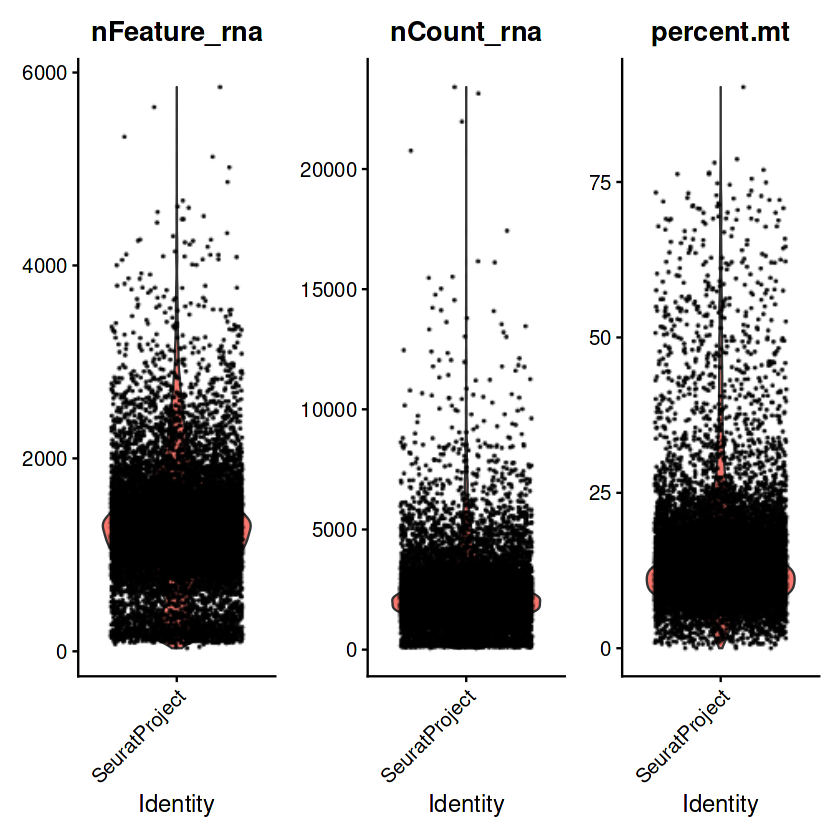

In [4]:
# RNA
# load data
counts <- Read10X(count_path)
rna_counts <- counts$`Gene Expression`
atac_counts <- counts$`Peaks`
rna <- gen_rna(rna_counts)
VlnPlot(rna, c("nFeature_rna", "nCount_rna", "percent.mt"),
        pt.size = 0.001, ncol = 3) + NoLegend()

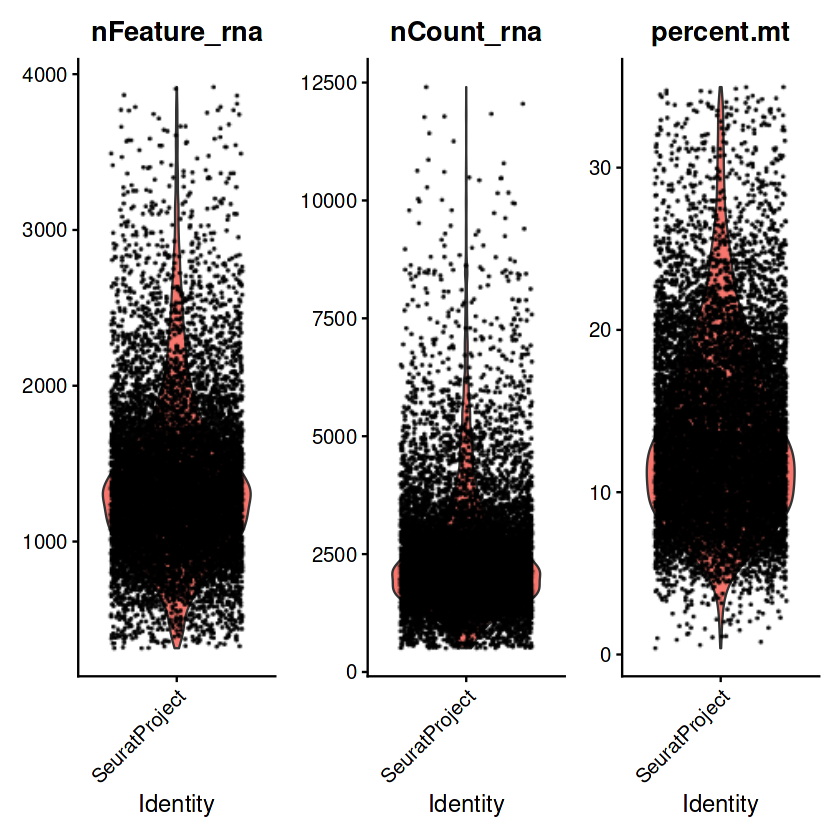

In [5]:
rna <- subset(rna, subset =
    nFeature_rna > 300 & nFeature_rna < 4000 &
    nCount_rna > 500 & nCount_rna < 15000 &
    percent.mt < 35
)
VlnPlot(rna, c("nFeature_rna", "nCount_rna", "percent.mt"),
        pt.size = 0.001, ncol = 3) + NoLegend()

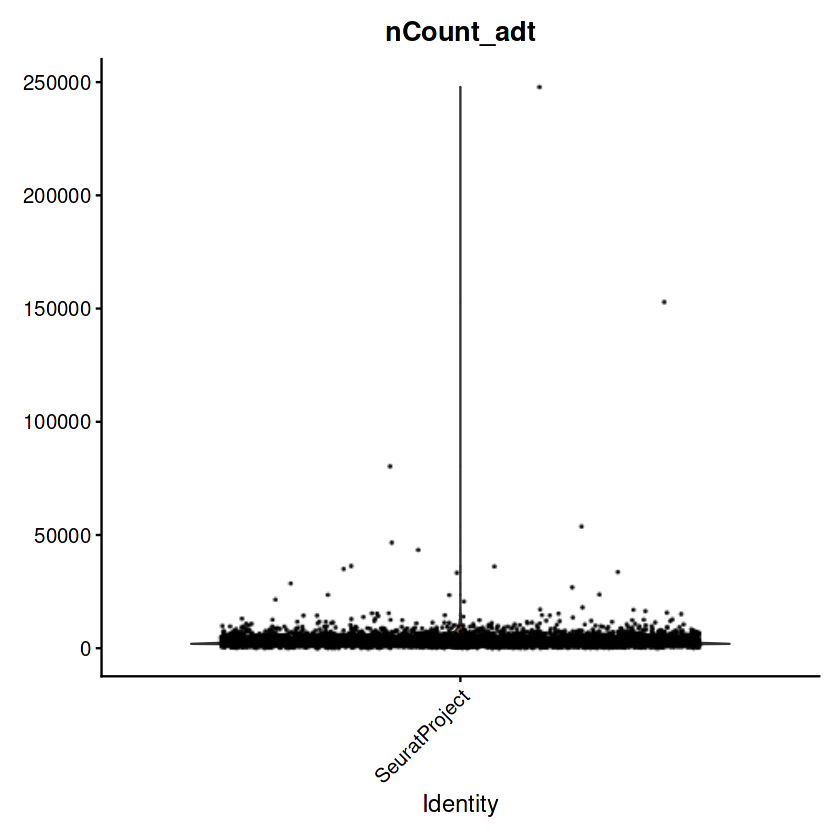

In [6]:
# ADT
# load data
adt_counts <- t(readMM(adt_path))  # D * N
adt_bc <- read.delim(adt_bc_path, header = F)
adt_feat <- read.delim(adt_feat_path, header = F)
colnames(adt_counts) <- paste0(adt_bc[, 1], "-1")
rownames(adt_counts) <- adt_feat[, 1]
adt_counts <- adt_counts[, colnames(rna_counts)]
adt <- gen_adt(adt_counts)
# QC
VlnPlot(adt, c("nCount_adt"), pt.size = 0.001, ncol = 1) + NoLegend()

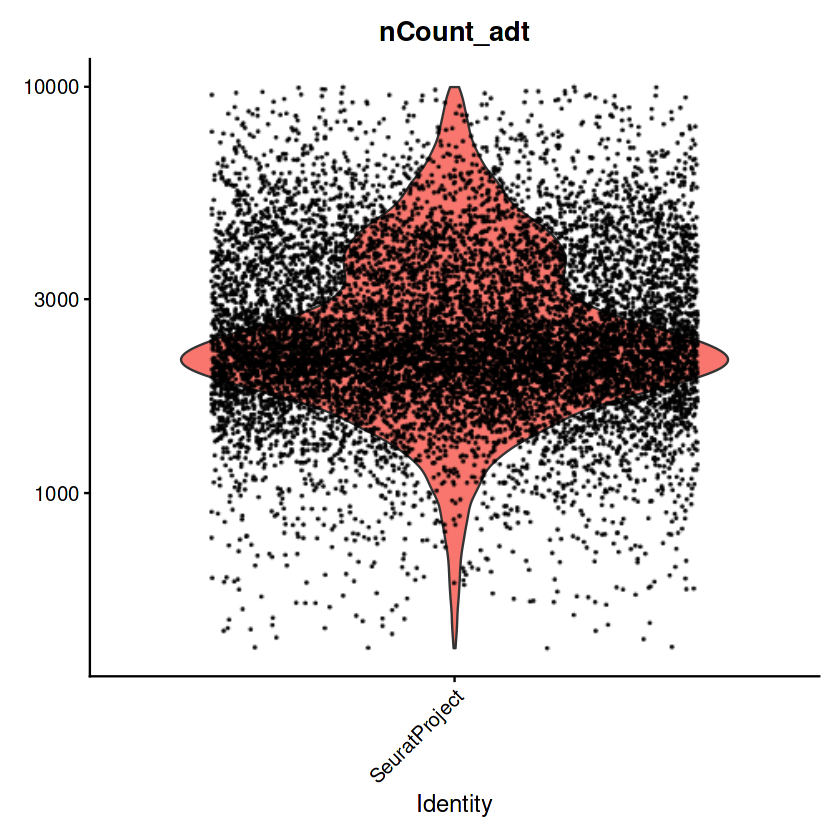

In [7]:
adt <- subset(adt, subset = nCount_adt > 400 & nCount_adt < 10000)
VlnPlot(adt, c("nCount_adt"), pt.size = 0.001, ncol = 1, log = T) + NoLegend()

Computing hash

Extracting reads overlapping genomic regions

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining intron

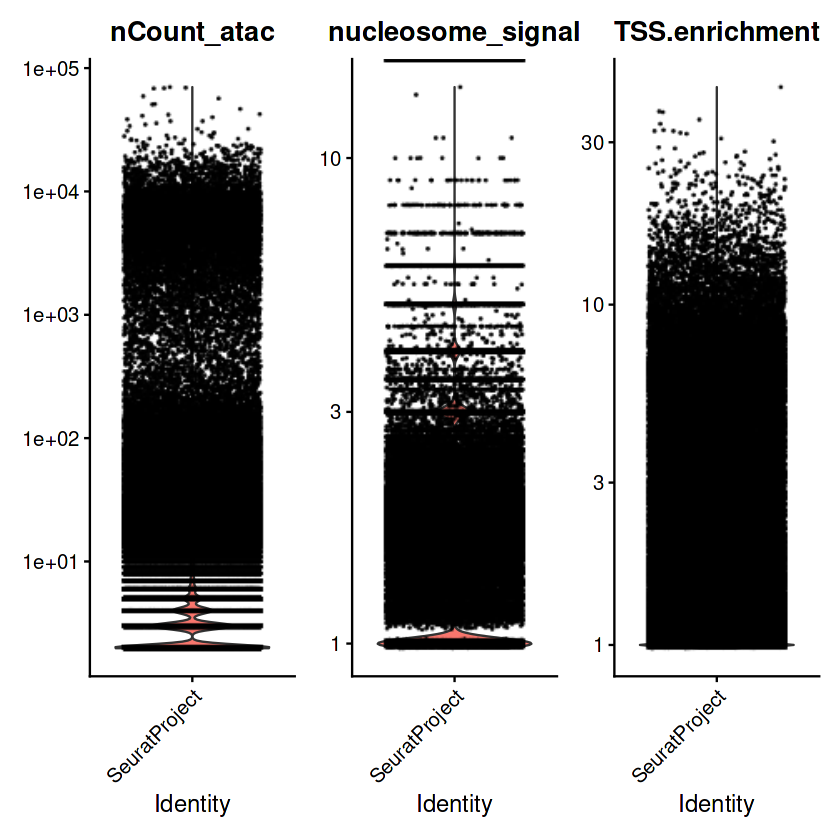

In [3]:
# ATAC
atac <- gen_atac(frag_path)
# QC
VlnPlot(atac, c("nCount_atac", "nucleosome_signal", "TSS.enrichment"),
        pt.size = 0.001, ncol = 3, log = T) + NoLegend()

In [ ]:
atac <- subset(atac, subset =
    nCount_atac > 500 & nCount_atac < 3e4 &
    nucleosome_signal < 2 &
    TSS.enrichment > 2
)
atac <- subset(atac, features = rownames(atac)[rowSums(atac$atac@counts > 0) > 5])
VlnPlot(atac, c("nCount_atac", "nucleosome_signal", "TSS.enrichment"),
        pt.size = 0.001, ncol = 3, log = F) + NoLegend()

In [ ]:
# Get intersected cells satisfying QC metrics of all modalities
cell_ids <- Reduce(intersect, list(colnames(atac), colnames(rna), colnames(adt)))
atac <- subset(atac, cells = cell_ids)
rna <- subset(rna, cells = cell_ids)
adt <- subset(adt, cells = cell_ids)
atac
rna
adt

In [ ]:
# preprocess and save data
preprocess(output_dir, atac = atac, rna = rna, adt = adt)